(12, 5000)


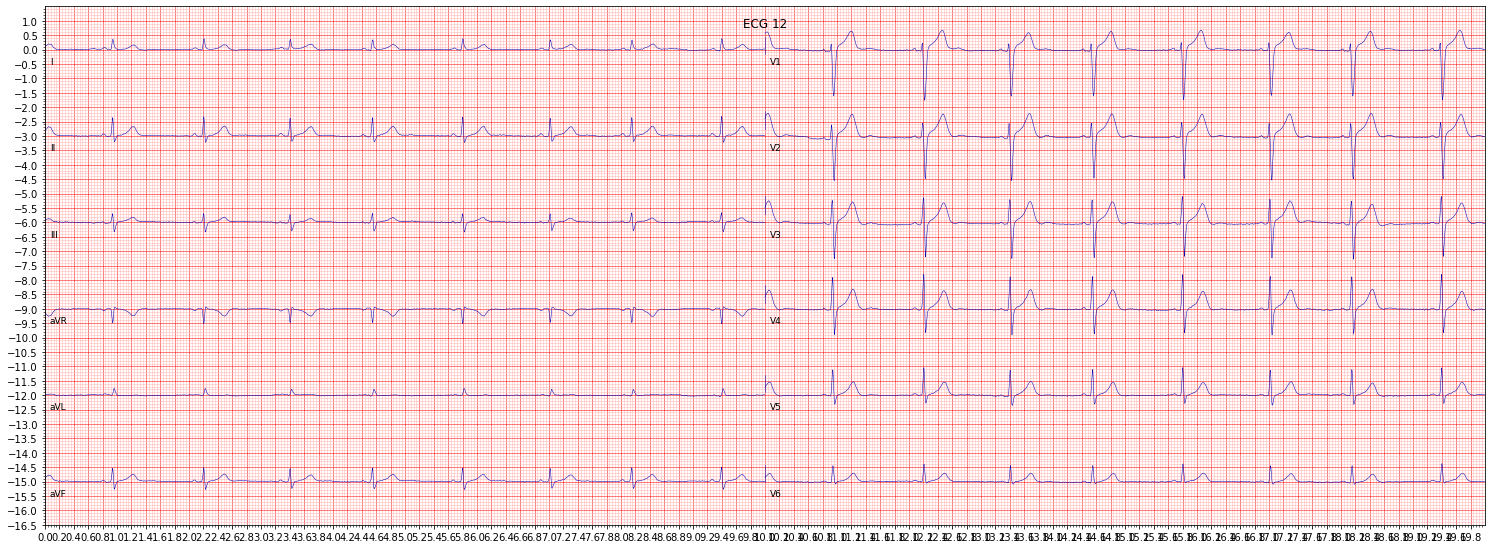

In [1]:
from scipy.io import loadmat
import ecg_plot

filename = "../data/train/TEST0001.mat"
image = loadmat(filename)
data_image = image["ecgdata"]
print(data_image.shape)


ecg_plot.plot(data_image, sample_rate = 500, title = 'ECG 12', columns=2)
ecg_plot.show()